In [1]:
RANDOM_STATE = 1234

In [2]:
import pandas as pd
import xgboost as xgb
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [3]:
trn = pd.read_csv("../data/normalized/TRN.csv")
tst_08SC = pd.read_csv("../data/normalized/TST_2008SC.csv")
tst1_19SC = pd.read_csv("../data/normalized/TST1_2019SC.csv")
tst2_19SC = pd.read_csv("../data/normalized/TST2_2019SC.csv")

trn_y, trn_X = trn["Solubility"], trn.drop("Solubility", axis=1)
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC.drop("Solubility", axis=1)
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC.drop("Solubility", axis=1)
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC.drop("Solubility", axis=1)

In [4]:
tune_space = {
    "eta": hp.choice("eta", [0.01, 0.1, 0.3]),
    "gamma": hp.uniform("gamma", 1, 9),
    "alpha": hp.quniform("alpha", 40, 180, 1),
    "lambda": hp.uniform("lambda", 0, 1),
    "max_depth": hp.randint("max_depth", 6, 10),
    "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),

    "objective": "reg:squarederror",

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "booster": "gbtree",  # ["gbtree", "gblinear", "dart"]
    "eval_metric": "rmse",
    "tree_method": "auto",  # ["auto", "hist", "exact", "approx"]
    "seed": RANDOM_STATE,

    "num_boost_round": hp.choice("num_boost_round", [100, 200, 300]),
    "nfold": 5
}

In [5]:
def tune_obj(space):
    eval_history = xgb.cv(
        params={
            "eta": space["eta"],
            "gamma": space["gamma"],
            "alpha": space["alpha"],
            "lambda": space["lambda"],
            "max_depth": space["max_depth"],
            "min_child_weight": space["min_child_weight"],
            "colsample_bytree": space["colsample_bytree"],

            "objective": space["objective"],

            "device": space["device"],
            "booster": space["booster"],
            "eval_metric": space["eval_metric"],
            "tree_method": space["tree_method"],
            "seed": space["seed"]
        },
        dtrain=xgb.DMatrix(data=trn_X, label=trn_y),
        num_boost_round=space["num_boost_round"],
        seed=space["seed"],
        metrics=space["eval_metric"],
        nfold=space["nfold"]
    )
    return {
        "loss": min(eval_history["test-rmse-mean"]),
        'status': STATUS_OK
    }

In [6]:
trials = Trials()
best_params = fmin(
    fn=tune_obj,
    space=tune_space,
    algo=tpe.suggest,
    max_evals=200,
    trials=trials
)

100%|██████████| 200/200 [1:16:01<00:00, 22.81s/trial, best loss: 0.8294579100838533]


In [7]:
best_params

{'alpha': 42.0,
 'colsample_bytree': 0.9960479463691504,
 'eta': 1,
 'gamma': 1.1055210927423804,
 'lambda': 0.7993390441866357,
 'max_depth': 9,
 'min_child_weight': 5.0,
 'num_boost_round': 0}

In [4]:
best_params = {
    "eta": 0.1,
    "gamma": 1.1055210927423804,
    "alpha": 42.0,
    "lambda": 0.7993390441866357,
    "max_depth": 9,
    "min_child_weight": 5.0,
    "colsample_bytree": 0.9960479463691504,

    "objective": "reg:squarederror",

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "tree_method": "auto",
    "seed": RANDOM_STATE,

    "num_boost_round": 100,
    "early_stopping_rounds": 10,
    "nfold": 5
}

In [18]:
xgb.cv(
    params={
        "eta": best_params["eta"],
        "gamma": best_params["gamma"],
        "alpha": best_params["alpha"],
        "lambda": best_params["lambda"],
        "max_depth": best_params["max_depth"],
        "min_child_weight": best_params["min_child_weight"],
        "colsample_bytree": best_params["colsample_bytree"],
        "objective": "reg:squarederror",
        "device": best_params["device"],
        "booster": best_params["booster"],
        "eval_metric": best_params["eval_metric"],
        "tree_method": best_params["tree_method"],
        "seed": best_params["seed"]
    },
    dtrain=xgb.DMatrix(data=trn_X, label=trn_y),
    num_boost_round=best_params["num_boost_round"],
    nfold=best_params["nfold"],
    metrics=best_params["eval_metric"],
    seed=best_params["seed"],
    early_stopping_rounds=best_params["early_stopping_rounds"],
    verbose_eval=True,
)

[0]	train-rmse:2.10513+0.01205	test-rmse:2.11049+0.04846
[1]	train-rmse:1.94978+0.01092	test-rmse:1.96030+0.04471
[2]	train-rmse:1.81187+0.00921	test-rmse:1.82931+0.04128
[3]	train-rmse:1.68942+0.00825	test-rmse:1.71283+0.03802
[4]	train-rmse:1.57918+0.00739	test-rmse:1.60917+0.03554
[5]	train-rmse:1.48244+0.00662	test-rmse:1.51951+0.03371
[6]	train-rmse:1.39580+0.00632	test-rmse:1.43961+0.03163
[7]	train-rmse:1.31891+0.00581	test-rmse:1.36939+0.03003
[8]	train-rmse:1.25045+0.00514	test-rmse:1.30817+0.02816
[9]	train-rmse:1.18910+0.00480	test-rmse:1.25367+0.02601
[10]	train-rmse:1.13431+0.00387	test-rmse:1.20552+0.02469
[11]	train-rmse:1.08577+0.00344	test-rmse:1.16379+0.02305
[12]	train-rmse:1.04303+0.00300	test-rmse:1.12708+0.02156
[13]	train-rmse:1.00483+0.00249	test-rmse:1.09494+0.02051
[14]	train-rmse:0.97102+0.00239	test-rmse:1.06724+0.01936
[15]	train-rmse:0.94065+0.00245	test-rmse:1.04253+0.01846
[16]	train-rmse:0.91278+0.00239	test-rmse:1.02083+0.01752
[17]	train-rmse:0.88792+

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2.105127,0.012047,2.110495,0.048456
1,1.949782,0.010923,1.960302,0.044712
2,1.811869,0.009215,1.829306,0.041276
3,1.689416,0.008253,1.712826,0.038020
4,1.579178,0.007385,1.609174,0.035544
...,...,...,...,...
60,0.611844,0.001483,0.830626,0.012665
61,0.610471,0.000911,0.830262,0.012798
62,0.609715,0.001608,0.829890,0.012260
63,0.608886,0.002491,0.829636,0.012195


In [5]:
booster = xgb.train(
    params={
        "eta": best_params["eta"],
        "gamma": best_params["gamma"],
        "alpha": best_params["alpha"],
        "lambda": best_params["lambda"],
        "max_depth": best_params["max_depth"],
        "min_child_weight": best_params["min_child_weight"],
        "colsample_bytree": best_params["colsample_bytree"],
        "objective": "reg:squarederror",
        "device": best_params["device"],
        "booster": best_params["booster"],
        "eval_metric": best_params["eval_metric"],
        "tree_method": best_params["tree_method"],
        "seed": best_params["seed"]
    },
    dtrain=xgb.DMatrix(data=trn_X, label=trn_y),
    num_boost_round=best_params["num_boost_round"]
)

In [6]:
tst1_19SC_pred = booster.predict(xgb.DMatrix(data=tst1_19SC_X))
tst2_19SC_pred = booster.predict(xgb.DMatrix(data=tst2_19SC_X))
tst_08SC_pred = booster.predict(xgb.DMatrix(data=tst_08SC_X))

In [13]:
performance = {
    "2019SC TST1 (RMSE)": mean_squared_error(tst1_19SC_y.values, tst1_19SC_pred, squared=False),
    "2019SC TST2 (RMSE)": mean_squared_error(tst2_19SC_y.values, tst2_19SC_pred, squared=False),
    "2008SC TST  (RMSE)": mean_squared_error(tst_08SC_y.values, tst_08SC_pred, squared=False),
    "2019SC TST1 (R^2)": r2_score(tst1_19SC_y.values, tst1_19SC_pred),
    "2019SC TST2 (R^2)": r2_score(tst2_19SC_y.values, tst2_19SC_pred),
    "2008SC TST  (R^2)": r2_score(tst_08SC_y.values, tst_08SC_pred),
}
performance

{'2019SC TST1 (RMSE)': 0.872091761971228,
 '2019SC TST2 (RMSE)': 1.2113892370670123,
 '2008SC TST  (RMSE)': 0.9442390495137737,
 '2019SC TST1 (R^2)': 0.5253874928692395,
 '2019SC TST2 (R^2)': 0.6800792717276551,
 '2008SC TST  (R^2)': 0.5158659221353303}

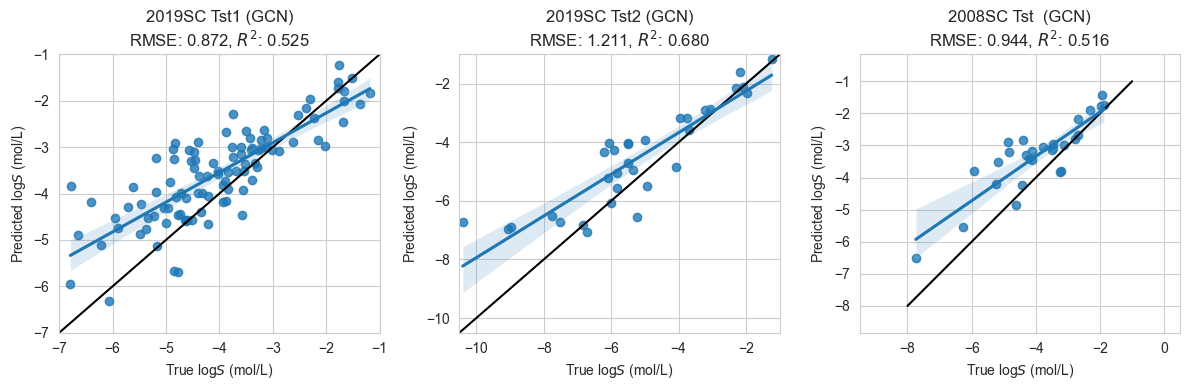

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "GCN"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -10.5, -1
min_ax3, max_ax3 = -8, -1

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")
sns.lineplot(x=[min_ax3, max_ax3], y=[min_ax3, max_ax3], ax=ax3, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst1_19SC_y.values,
        "Predicted log$S$ (mol/L)": tst1_19SC_pred
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst2_19SC_y.values,
        "Predicted log$S$ (mol/L)": tst2_19SC_pred
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax2
)
sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst_08SC_y.values,
        "Predicted log$S$ (mol/L)": tst_08SC_pred
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax3
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)
ax3.set_xlim(min_ax3, max_ax3)
ax3.set_ylim(min_ax3, max_ax3)

ax1.set_title(f"2019SC Tst1 ({model_name})\n"
              f"RMSE: {performance['2019SC TST1 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST1 (R^2)']:.3f}")
ax2.set_title(f"2019SC Tst2 ({model_name})\n"
              f"RMSE: {performance['2019SC TST2 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST2 (R^2)']:.3f}")
ax3.set_title(f"2008SC Tst  ({model_name})\n"
              f"RMSE: {performance['2008SC TST  (RMSE)']:.3f}, "
              f"$R^2$: {performance['2008SC TST  (R^2)']:.3f}")

plt.axis("equal")
plt.tight_layout()